In [ ]:
!pip install rudolph==0.0.1rc10 

In [1]:
import torch
from rudalle import get_vae
from rudalle.utils import seed_everything

import sys
sys.path.insert(0, 'ru-dolph')

import os
from glob import glob
from os.path import join
from datetime import datetime

import torch
import bitsandbytes as bnb
from torch.utils.data import Dataset, DataLoader
import torchvision
import transformers
import more_itertools
import numpy as np
import json
from PIL import Image, ImageDraw
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm
from einops import rearrange
import youtokentome as yttm

import torchvision
from rudalle.image_prompts import ImagePrompts
from rudolph.model import get_rudolph_model, ruDolphModel, FP16Module
from rudolph import utils
from rudolph.model.utils import get_attention_mask
from rudalle import get_tokenizer, get_vae
from rudolph.api import ruDolphApi

import datasets
import random

C:\ProgramData\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import matplotlib.pyplot as plt

In [3]:
device = 'cuda'

In [4]:
model = get_rudolph_model('1.3B', pretrained=True, fp16=True, device='cuda', cache_dir=r'D:\AIRI\ru-dolph\cached_models\rudolph')

C:\ProgramData\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:624: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


In [5]:
tokenizer = get_tokenizer()
vae = get_vae(dwt=False).to(device)

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


In [6]:
class Args():
    def __init__(self, model, checkpoint_path):
        self.device = model.get_param('device')
        self.l_text_seq_length = model.get_param('l_text_seq_length')
        self.r_text_seq_length = model.get_param('r_text_seq_length')
        self.image_tokens_per_dim = model.get_param('image_tokens_per_dim')
        self.image_seq_length = model.get_param('image_seq_length')
        self.epochs = 1
        self.save_path= checkpoint_path
        self.model_name = 'rudolph_sberquad_'
        self.save_every = 1000
        self.bs = 1
        self.clip = 1.0
        self.lr = 2e-5
        self.wandb = False
        self.lt_loss_weight = 0.01
        self.img_loss_weight = 0.01
        self.rt_loss_weight = 7
        self.bin_size = 8
        self.image_size = self.image_tokens_per_dim * self.bin_size
        
checkpoint_path = './model/checkpoints/'
args = Args(model, checkpoint_path)
if not os.path.exists(args.save_path):
    os.makedirs(args.save_path)

In [7]:
SPC_TOKENS = {
    '<LT_UNK>': 16384,
    '<RT_UNK>': 16385,
    '<LT_T2I>': 16386,
    '<LT_I2T>': 16387,
    '<LT_T2T>': 16388,
    '<RT_I2T>': 16389,
    
    '<LT_TQA>': 16390,
    '<RT_TQA>': 16391,
    '<LT_PG>': 16392,
    '<RT_PG>': 16393,
}

Добавляем локализационные токены

In [8]:
for n in range(args.image_tokens_per_dim):
    n_token = SPC_TOKENS['<RT_PG>']+1+n
    SPC_TOKENS['<RT_PG'+str(n)+'>'] = n_token

In [9]:
print(SPC_TOKENS)

{'<LT_UNK>': 16384, '<RT_UNK>': 16385, '<LT_T2I>': 16386, '<LT_I2T>': 16387, '<LT_T2T>': 16388, '<RT_I2T>': 16389, '<LT_TQA>': 16390, '<RT_TQA>': 16391, '<LT_PG>': 16392, '<RT_PG>': 16393, '<RT_PG0>': 16394, '<RT_PG1>': 16395, '<RT_PG2>': 16396, '<RT_PG3>': 16397, '<RT_PG4>': 16398, '<RT_PG5>': 16399, '<RT_PG6>': 16400, '<RT_PG7>': 16401, '<RT_PG8>': 16402, '<RT_PG9>': 16403, '<RT_PG10>': 16404, '<RT_PG11>': 16405, '<RT_PG12>': 16406, '<RT_PG13>': 16407, '<RT_PG14>': 16408, '<RT_PG15>': 16409, '<RT_PG16>': 16410, '<RT_PG17>': 16411, '<RT_PG18>': 16412, '<RT_PG19>': 16413, '<RT_PG20>': 16414, '<RT_PG21>': 16415, '<RT_PG22>': 16416, '<RT_PG23>': 16417, '<RT_PG24>': 16418, '<RT_PG25>': 16419, '<RT_PG26>': 16420, '<RT_PG27>': 16421, '<RT_PG28>': 16422, '<RT_PG29>': 16423, '<RT_PG30>': 16424, '<RT_PG31>': 16425}


In [10]:
torch.manual_seed(42)

добавляем правый и нижний паддинги и ресайзим до 256x256, чтобы на выходе vae получить последовательность длины 1024

In [15]:
class RightDownPad:
    def __call__(self, image):
        _, h, w = image.size()
        max_wh = max(w, h)
        hp = int(max_wh - w)
        vp = int(max_wh - h)
        padding = [0, 0, hp, vp]
        return TF.pad(image, padding)
    
image_transform = T.Compose([
    T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
    T.ToTensor(),
    RightDownPad(),
    T.Resize((args.image_size, args.image_size))
    ])

In [33]:
class VisualGenomeDataset(Dataset):
    spc_id = -1
    
    def __init__(self, annotation_path, images_root, image_transform, tokenizer, args):
        self.tokenizer = tokenizer
        self.args = args
        
        self.spc_tokens = SPC_TOKENS
        self.n_bins = self.args.image_tokens_per_dim
        self.bin_size = self.args.bin_size
        self.image_size = self.args.image_size
        
        self.image_transform = image_transform
        self.images_root = images_root
        with open(annotation_path, 'rb') as fj:
            annotation = json.load(fj)

        self.images = []
        self.bboxs = []
        self.phrases = []

        for image_name in annotation.keys():
            ann_img = annotation[image_name]
            for phrase in ann_img.keys():
                self.phrases.append(phrase)
                self.images.append(image_name)
                self.bboxs.append(ann_img[phrase][0])
        
    def __len__(self):
        return len(self.phrases)
    
    def encode_text(self, text, text_seq_length, add_special = True):
        tokens = self.tokenizer.tokenizer.encode([text], output_type=yttm.OutputType.ID)[0]
        bos = [self.tokenizer.bos_id]
        if add_special:
            bos.append(self.spc_id)
        tokens = bos + tokens + [self.tokenizer.eos_id]
        return self.tokenizer.prepare_tokens(tokens, text_seq_length)
    
    def resize_and_encode_bbox(self, bbox, img_size):
        bbox_x0 = bbox[0]
        bbox_y0 = bbox[1]
        bbox_x1 = bbox_x0+bbox[2]
        bbox_y1 = bbox_y0+bbox[3]
        
        img_w = img_size[0]
        img_h = img_size[1]
        
        max_wh = max(img_w,img_h)

        resized_x0 = int(bbox_x0*image_size/max_wh)
        resized_y0 = int(bbox_y0*image_size/max_wh)
        resized_x1 = int(bbox_x1*image_size/max_wh)
        resized_y1 = int(bbox_y1*image_size/max_wh)
        
        
        bbox_x0_bin = resized_x0//self.bin_size
        bbox_y0_bin = resized_y0//self.bin_size
        bbox_x1_bin = resized_x1//self.bin_size
        bbox_y1_bin = resized_y1//self.bin_size
        
        new_bbox_tokens = [self.tokenizer.bos_id, SPC_TOKENS['<RT_PG>']] + \
                            [SPC_TOKENS['<RT_PG'+str(bbox_x0_bin)+'>'],
                           SPC_TOKENS['<RT_PG'+str(bbox_y0_bin)+'>'],
                           SPC_TOKENS['<RT_PG'+str(bbox_x1_bin)+'>'],
                           SPC_TOKENS['<RT_PG'+str(bbox_y1_bin)+'>']]
        new_bbox_tokens += [0]*(self.args.l_text_seq_length-5)
        
        return torch.Tensor(new_bbox_tokens)
    
    def load_image(self, image_name: str) -> Image.Image:
        return Image.open(os.path.join(self.images_root, image_name)).convert("RGB")
   
    def __getitem__(self, item):
        
        left_text = self.phrases[item]
        
        left_special_token = '<LT_PG>'
        right_special_token = '<RT_PG>'
        
        left_text = left_text.lower().strip()
        left_encoded_text = self.encode_text(left_text, text_seq_length=self.args.l_text_seq_length)
        left_encoded_text[torch.where(left_encoded_text == self.spc_id)] = self.spc_tokens[left_special_token]

        pil_img = self.load_image(self.images[item])
        pil_img_size = pil_img.size
        
        right_encoded_text = self.resize_and_encode_bbox(self.bboxs[item], img_size=pil_img_size)
        
        img = self.image_transform(pil_img)
        
        return left_encoded_text, img, right_encoded_text

In [13]:
def freeze(
    model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
):
    for name, p in model.module.named_parameters():
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
    return model

In [ ]:
#wget annotation_path
#wget images_root

In [16]:
images_root = r'D:\AIRI\fusion_brain_data\visual_genome'
annotation_path = r'D:\AIRI\fusion_brain_data\vg_intersection_rus.json'

In [34]:
dataset_pg = VisualGenomeDataset(annotation_path, images_root, args = args, image_transform=image_transform, tokenizer=tokenizer)

In [35]:
sample_loader = DataLoader(dataset_pg, batch_size=1, shuffle=True, drop_last=True)

Посмотреть семпл и рамки

In [26]:
def decode_text(tokenizer, encoded, ignore_ids):
    return tokenizer.tokenizer.decode(encoded.cpu().numpy().tolist(), ignore_ids=ignore_ids)[0]

In [28]:
ignore_ids = [
    tokenizer.eos_id, tokenizer.bos_id, tokenizer.unk_id, tokenizer.pad_id,
    -1, *list(SPC_TOKENS.values())
]

In [36]:
encoded_left_text, image, encoded_right_text = next(iter(sample_loader))

черное переднее колесо


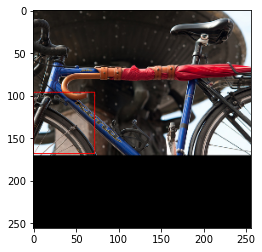

In [38]:
img_np = image[0].permute(1,2,0).numpy()*255
pil_img = Image.fromarray(img_np.astype(np.uint8))
t_draw = ImageDraw.Draw(pil_img)

print(decode_text(tokenizer, encoded_left_text, ignore_ids))

bin_box_x0 = encoded_right_text[0][2]-SPC_TOKENS['<RT_PG>']-1
bin_box_y0 = encoded_right_text[0][3]-SPC_TOKENS['<RT_PG>']-1
bin_box_x1 = encoded_right_text[0][4]-SPC_TOKENS['<RT_PG>']-1
bin_box_y1 = encoded_right_text[0][5]-SPC_TOKENS['<RT_PG>']-1

t_draw.rectangle((args.bin_size*bin_box_x0, args.bin_size*bin_box_y0, args.bin_size*bin_box_x1, args.bin_size*bin_box_y1),
                 outline=255)
plt.imshow(pil_img)

In [291]:
train_dataloader = DataLoader(dataset_pg, batch_size=args.bs, shuffle=True, drop_last=True)

In [90]:
model.train()
optimizer = bnb.optim.Adam8bit(model.parameters(), lr=args.lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=args.lr, final_div_factor=500, 
    steps_per_epoch=len(train_dataloader), epochs=args.epochs
)

NameError: name 'bnb' is not defined

In [ ]:
def load_checkpoint(model, optimizer, losslogger, filename='checkpoint.pt'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, losslogger

In [304]:
def train(model, optimizer, scheduler, args: Args, train_dataloader, from_checkpoints = False):
    """
      args - arguments for training

      train_dataloader - VisualGenomeDataset
      """
    loss_logs = []
    try:
        t_steps = len(train_dataloader)*args.epochs
        progress = tqdm(total = t_steps, desc='🦌🦌🦌finetuning process🦌🦌🦌')
    
        save_counter = 0
        start_epoch = 0
        
        if from_checkpoints:
            model, optimizer, start_epoch, loss_logs = load_checkpoint(model, optimizer, loss_logs, filename=os.path.join(args.save_path,f"rudolph_sberquad_state6.pt"))
        
        for epoch in range(start_epoch, args.epochs):
            
            for encoded_left_text, images, encoded_right_text in train_dataloader: #, prompt, image, locs
        
                bs_text = encoded_left_text.shape[0]

                images = images.to(device)

                image_seq_length = args.image_tokens_per_dim ** 2
                total_seq_length = args.l_text_seq_length + image_seq_length + args.r_text_seq_length
                encoded_images = vae.get_codebook_indices(images, disable_gumbel_softmax=True)

                attention_mask_text = get_attention_mask(bs_text, args.l_text_seq_length,
                                                 args.image_tokens_per_dim, 
                                                 args.r_text_seq_length, args.device)

                input_ids_text = torch.cat((encoded_left_text.to(args.device).int(),
                                encoded_images.int(),
                                encoded_right_text.to(args.device).int()), dim=1)
                loss, loss_values = model.forward(input_ids_text, attention_mask_text, 
                                                                 lt_loss_weight=args.lt_loss_weight,
                                                                 img_loss_weight=args.img_loss_weight, 
                                                                 rt_loss_weight=args.rt_loss_weight, return_loss=True)


                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(),args.clip)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                if save_counter % args.save_every == 0:
                    print(f'Saving checkpoint here {args.model_name}_rudolph_{save_counter}.pt')
                    plt.plot(loss_logs)
                    plt.show()
                    state = {'epoch': epoch + 1, 'state_dict': model.state_dict(),
                             'optimizer': optimizer.state_dict(), 'losslogger': loss_logs}
                    torch.save(
                        model.state_dict(),
                        os.path.join(args.save_path,f"{args.model_name}rudolph_{save_counter}.pt")
                    )
                    torch.save(
                        state,
                        os.path.join(args.save_path,f"{args.model_name}state_{save_counter}.pt")
                    )

                loss_logs+=[loss.item()]
                progress.update()
                progress.set_postfix({"loss": loss.item()})

            print(f'Complitly tuned and saved here  {args.model_name}__textqa_last.pt')
            plt.plot(loss_logs)
            plt.show()
            torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.model_name}textqa_last.pt")
            )
    except KeyboardInterrupt:


        print(f'What for did you stopped? Please change model_path to /{args.save_path}/{args.model_name}_rudolf_Failed_train')
        plt.plot(loss_logs)
        plt.show()

        torch.save(
                model.state_dict(),
                os.path.join(args.save_path,f"{args.model_name}_rudolf_Failed_train.pt")
                )
    except Exception as err:
        print(f'Failed with {err}')

In [305]:
optimizer = None
scheduler = None

In [306]:
model = freeze(
    model=model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
)

train(model, optimizer, scheduler, args, train_dataloader)

🦌🦌🦌finetuning process🦌🦌🦌:   0%|          | 0/39915 [00:00<?, ?it/s]

Failed with CUDA out of memory. Tried to allocate 200.00 MiB (GPU 0; 8.00 GiB total capacity; 6.47 GiB already allocated; 0 bytes free; 6.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
